In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

In [2]:
data = pd.read_csv('card_transdata.csv', sep=',')

In [3]:
X = data.drop(columns=['fraud'])
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Modèle XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [6]:
model_xgb.fit(X_train, y_train)

c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [7]:
# Prédictions
y_pred_xgb = model_xgb.predict(X_test)

# Évaluation
print("XGBoost :")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.98      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000

[[182082    437]
 [     6  17475]]


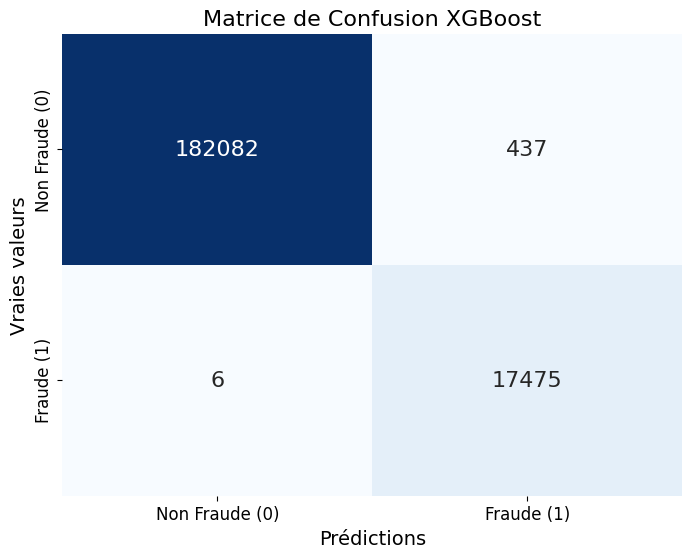

In [8]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_xgb)

# Création du graphique
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Ajout des labels et du titre
plt.xlabel('Prédictions', fontsize=14)
plt.ylabel('Vraies valeurs', fontsize=14)
plt.title('Matrice de Confusion XGBoost', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Non Fraude (0)', 'Fraude (1)'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['Non Fraude (0)', 'Fraude (1)'], fontsize=12)

# Afficher le graphique
plt.show()

AUC-ROC pour le modèle XGBoost : 1.0000


C:\Users\delah\AppData\Local\Temp\ipykernel_27596\3216568135.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', color='red')


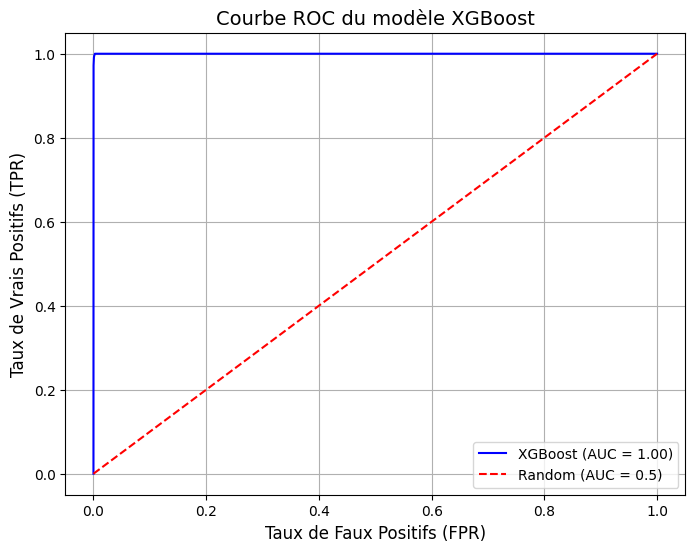

In [9]:
# Obtenir les probabilités pour la classe positive (fraude)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Calcul du score AUC-ROC
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC-ROC pour le modèle XGBoost : {auc_xgb:.4f}")

# Calcul des courbes ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', color='red')

# Personnalisation du graphique
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC du modèle XGBoost', fontsize=14)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [10]:
from sklearn.metrics import fbeta_score

# Calcul du F2-score
f2 = fbeta_score(y_test, y_pred_xgb, beta=2)
print(f"F2-score : {f2:.4f}")

F2-score : 0.9948


In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

# Définir le modèle XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Définir le scorer basé sur le F2-score
f2_scorer = make_scorer(fbeta_score, beta=2)

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Effectuer la recherche en grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F2 :", grid_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Évaluer les performances du modèle
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("F2-score :", fbeta_score(y_test, y_pred, beta=2))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Valeurs")
plt.show()

# Courbe ROC et AUC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 